Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Platform (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Year_of_Release (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Genre (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Publisher (InputLayer)         [(None, 1)]          0           []                               
                                                                                            

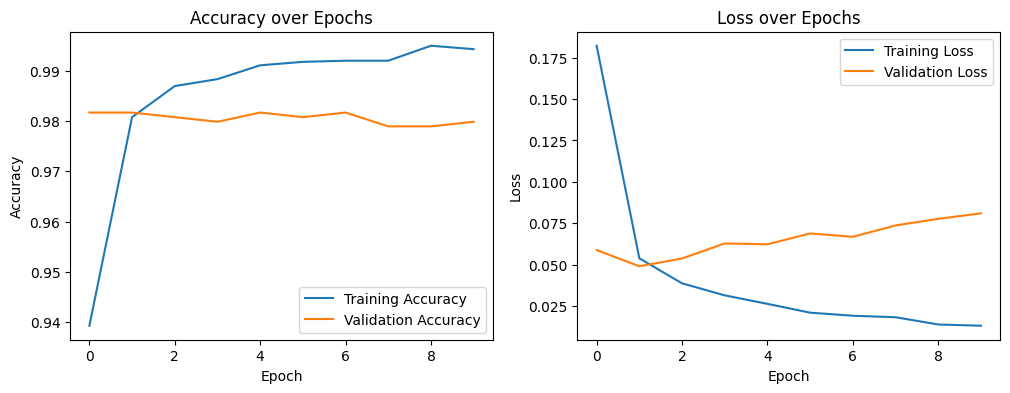

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate
import joblib

# Load the dataset
df = pd.read_csv('Video_Games.csv')

# Save the scaler and label encoders for future use
joblib.dump(scaler, 'scaler.pkl')
for col, encoder in label_encoders.items():
    joblib.dump(encoder, f'{col}_encoder.pkl')

# Drop rows with missing values and unnecessary columns
df.dropna(inplace=True)
df.drop(['Name', 'EU_Sales', 'Other_Sales'], axis=1, inplace=True)

# Convert 'Global_Sales' into a binary classification problem
df['Global_Sales'] = df['Global_Sales'].apply(lambda x: 1 if x > 2 else 0)

# Define numerical and categorical columns
numerical_columns = ['NA_Sales', 'JP_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
categorical_columns = ['Platform', 'Year_of_Release', 'Genre', 'Publisher', 'Developer', 'Rating']

# Scale numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Split the data into features and target
X = df[numerical_columns + categorical_columns]
y = df['Global_Sales']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model inputs
input_numerical = Input(shape=(len(numerical_columns),), name='num_input')
input_categorical = {col: Input(shape=(1,), name=col) for col in categorical_columns}

# Create embedding layers for each input layer
embedding_layers = []
for col, input_layer in input_categorical.items():
    num_unique_values = df[col].max() + 1
    embedding_size = int(min(np.ceil(num_unique_values/2), 50))
    embedding_layer = Embedding(input_dim=num_unique_values,
                                output_dim=embedding_size,
                                input_length=1)(input_layer)
    flatten_layer = Flatten()(embedding_layer)
    embedding_layers.append(flatten_layer)

concat_layer = concatenate([input_numerical] + embedding_layers)

# Add dense layers
dense_layer_1 = Dense(128, activation='relu')(concat_layer)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

# Create and compile the model
model = Model(inputs=[input_numerical] + list(input_categorical.values()), outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Prepare the training inputs
train_inputs = [X_train[numerical_columns]] + [X_train[col] for col in categorical_columns]

# Train the model
history = model.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Prepare the testing inputs
test_inputs = [X_test[numerical_columns]] + [X_test[col] for col in categorical_columns]

# Evaluate the model
loss, accuracy = model.evaluate(test_inputs, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('video_game_sales_model.h5')


In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Load the dataset
df = pd.read_csv('Video_Games.csv')

# Define columns
numerical_columns = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
categorical_columns = ['Platform', 'Year_of_Release', 'Genre', 'Publisher', 'Developer', 'Rating']
text_column = 'Name'
target_columns = ['NA_Sales', 'JP_Sales', 'EU_Sales', 'Other_Sales']

# Preprocessing Steps
df.dropna(subset=numerical_columns + categorical_columns + target_columns + [text_column], inplace=True)

# Scale numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Encode categorical columns
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_columns}
for col in categorical_columns:
    df[col] = label_encoders[col].transform(df[col])

# Tokenize text column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df[text_column])
max_length = max(len(s.split()) for s in df[text_column])
vocab_size = len(tokenizer.word_index) + 1
text_sequences = tokenizer.texts_to_sequences(df[text_column])
text_data = pad_sequences(text_sequences, maxlen=max_length)

# Splitting the dataset
X = df[numerical_columns + categorical_columns]
X_text = text_data
y = df[target_columns]
X_train, X_test, X_text_train, X_text_test, y_train, y_test = train_test_split(X, X_text, y, test_size=0.2, random_state=42)

# Enhanced Model Building
def build_model():
    numerical_input = Input(shape=(len(numerical_columns),), name='num_input')
    categorical_input = [Input(shape=(1,), name=f'cat_input_{i}') for i in range(len(categorical_columns))]
    text_input = Input(shape=(max_length,), name='text_input')

    embedding_layers = []
    for col, input_layer in zip(categorical_columns, categorical_input):
        num_unique_values = len(label_encoders[col].classes_)
        embedding_layer = Embedding(input_dim=num_unique_values, output_dim=min(num_unique_values // 2, 50), input_length=1)(input_layer)
        flatten_layer = Flatten()(embedding_layer)
        embedding_layers.append(flatten_layer)

    text_embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length)(text_input)  # Increased output_dim
    text_lstm = LSTM(100)(text_embedding)  # Increased LSTM units

    concat_layer = concatenate([numerical_input] + embedding_layers + [text_lstm])

    dense_layer_1 = Dense(256,activation='relu')(concat_layer) # Increased number of neurons
    dropout_1 = Dropout(0.6)(dense_layer_1) # Increased dropout
    dense_layer_2 = Dense(128, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.6)(dense_layer_2)
    output_layer = Dense(len(target_columns), activation='linear')(dropout_2)
    
    model = Model(inputs=[numerical_input] + categorical_input + [text_input], outputs=output_layer)
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

#K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train_index, val_index in kf.split(X_train):
    model = build_model()  # Indentation added here

    train_inputs = [X_train.iloc[train_index][numerical_columns].values] + \
                   [X_train.iloc[train_index][col].values for col in categorical_columns] + \
                   [X_text_train[train_index]]
    val_inputs = [X_train.iloc[val_index][numerical_columns].values] + \
                 [X_train.iloc[val_index][col].values for col in categorical_columns] + \
                 [X_text_train[val_index]]
    y_train_fold,y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    history = model.fit(train_inputs, y_train_fold.values, epochs=10, batch_size=32, validation_data=(val_inputs, y_val_fold.values))
    

model.save('video_game_sales_model_enhanced.h5')
joblib.dump(scaler, 'scaler_enhanced.pkl')
joblib.dump(tokenizer, 'tokenizer_enhanced.pkl')
for col, encoder in label_encoders.items():
    joblib.dump(encoder, f'label_encoder_{col}_enhanced.pkl')

print("Enhanced model training complete. Model and preprocessing tools saved.")

Epoch 1/10
137/137 [==============================] - 11s 64ms/step - loss: 0.5262 - mae: 0.3309 - val_loss: 0.2532 - val_mae: 0.2198
Epoch 2/10
137/137 [==============================] - 4s 28ms/step - loss: 0.4474 - mae: 0.2609 - val_loss: 0.2564 - val_mae: 0.2575
Epoch 3/10
137/137 [==============================] - 3s 24ms/step - loss: 0.4242 - mae: 0.2796 - val_loss: 0.3731 - val_mae: 0.4328
Epoch 4/10
137/137 [==============================] - 3s 24ms/step - loss: 0.4147 - mae: 0.3082 - val_loss: 0.2337 - val_mae: 0.2674
Epoch 5/10
137/137 [==============================] - 3s 23ms/step - loss: 0.4426 - mae: 0.3473 - val_loss: 0.4203 - val_mae: 0.4591
Epoch 6/10
137/137 [==============================] - 3s 23ms/step - loss: 0.5680 - mae: 0.4322 - val_loss: 0.3342 - val_mae: 0.3568
Epoch 7/10
137/137 [==============================] - 3s 23ms/step - loss: 0.9120 - mae: 0.5524 - val_loss: 0.6159 - val_mae: 0.5066
Epoch 8/10
137/137 [==============================] - 3s 23ms/step -

/Users/abishek/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
